In [ ]:
%config InlineBackend.figure_format = "retina"
%matplotlib inline
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,Normalize

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, vmap
jax.config.update('jax_enable_x64', True)

from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd

#!pip3 install pickle5
#import pickle5 as pickle

Mounted at /content/gdrive


In [ ]:
paths = {'AAPL': '/content/gdrive/MyDrive/datasets/AAPL.csv',
         'VOO': '/content/gdrive/MyDrive/datasets/VOO.csv',
         'CVX': '/content/gdrive/MyDrive/datasets/CVX.csv',
         'AAAU': '/content/gdrive/MyDrive/datasets/AAAU.csv',
         'VTSAX': '/content/gdrive/MyDrive/datasets/VTSAX.csv',
         'BNDX': '/content/gdrive/MyDrive/datasets/BNDX.csv',
         'PXI': '/content/gdrive/MyDrive/datasets/PXI.csv'}


# Loading the data

data = {}
means = {}
T = 250 #days

for ticker in paths.keys():
    # Import ticker data
    df = pd.read_csv(paths[ticker]).tail(T)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Log'] = np.log(df['Adj Close'])
    #df['Log Return'] = df['Log'].shift(-1) - df['Log']

    # Ticker log-returns
    _ = df['Log'].to_numpy()

    means[ticker] = jnp.mean(_)
    data[ticker] = _ - means[ticker]

df_raw = pd.DataFrame.from_dict(data)


#Baby example

In [ ]:
# Data

N = 128
df = df_raw.head(N)

x0 = df.index.to_numpy()
y0 = df['AAPL'].to_numpy()

x1 = df.index.to_numpy()
y1 = df['VOO'].to_numpy()

data = [jnp.asarray([x0, y0]), jnp.asarray([x1, y1])]


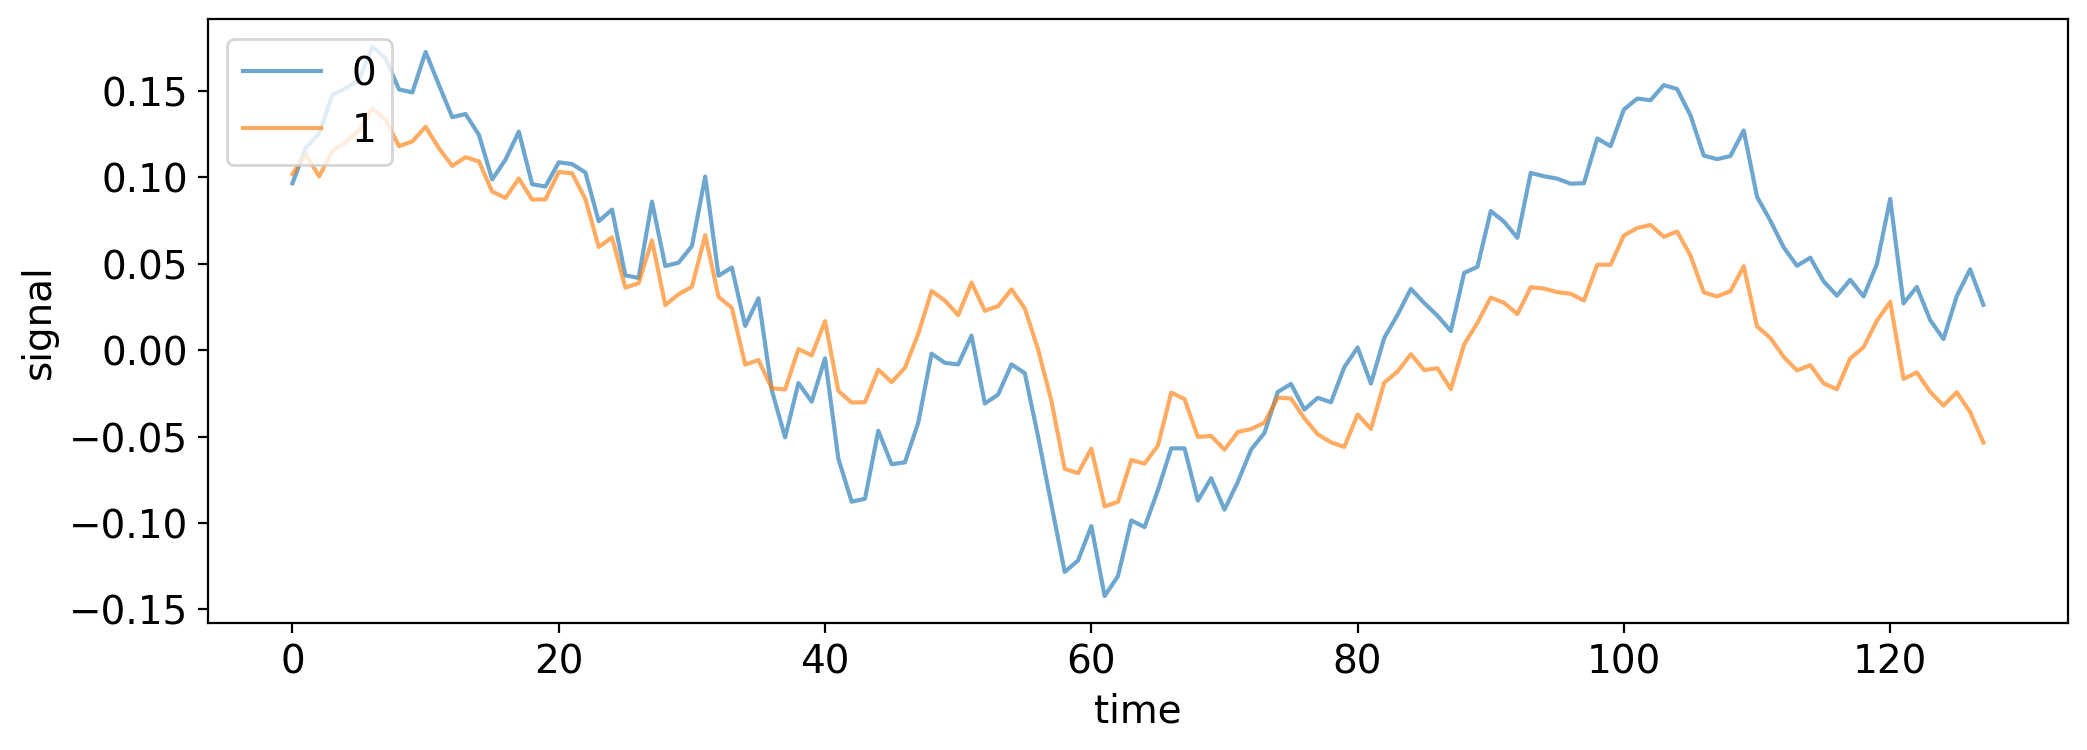

In [ ]:
# Plot

plt.figure(figsize=(12,4))

for idx, _ in enumerate(data):
    _xdata = _[0]
    _ydata = _[1]
    plt.plot(_xdata, _ydata, alpha=0.65, label=idx, zorder=1)

plt.legend(loc='upper left')
plt.xlabel('time')
plt.ylabel('signal')

plt.show()

In [ ]:
# Define a basic Kernel

def matern(t, s, params=1):
    sigma = params
    d = jnp.abs(t - s)
    u = jnp.power(3,1/2) * d / sigma
    return sigma**2 * (1+u) * jnp.exp(-u)

vmatern = vmap(matern, in_axes=(None, 0, None))

In [ ]:
params = [5, 1, 5]

# Construct the kernel

k00 = vmatern(data[0][0], data[0][0], params[0])
k01 = vmatern(data[0][0], data[1][0], params[1])
k10 = vmatern(data[1][0], data[0][0], params[1])
k11 = vmatern(data[1][0], data[1][0], params[2])

sigma0 = jnp.eye(len(k00))
sigma1 = jnp.eye(len(k11))

K = jnp.block(
    [[k00 + sigma0, k01],
     [k10, k11 + sigma1]]
)


coef = jnp.linalg.solve(K, jnp.concatenate((y0, y1)))

In [ ]:
x_star = jnp.linspace(0,150,512)

k00_star = vmatern(data[0][0], x_star, params[0])
k01_star = vmatern(data[1][0], x_star, params[1])
k10_star = vmatern(data[0][0], x_star, params[1])
k11_star = vmatern(data[1][0], x_star, params[2])

K_star = jnp.block(
    [[k00_star, k01_star],
     [k10_star, k11_star]]
)

y_star = jnp.asarray(jnp.split(K_star @ coef, 2))

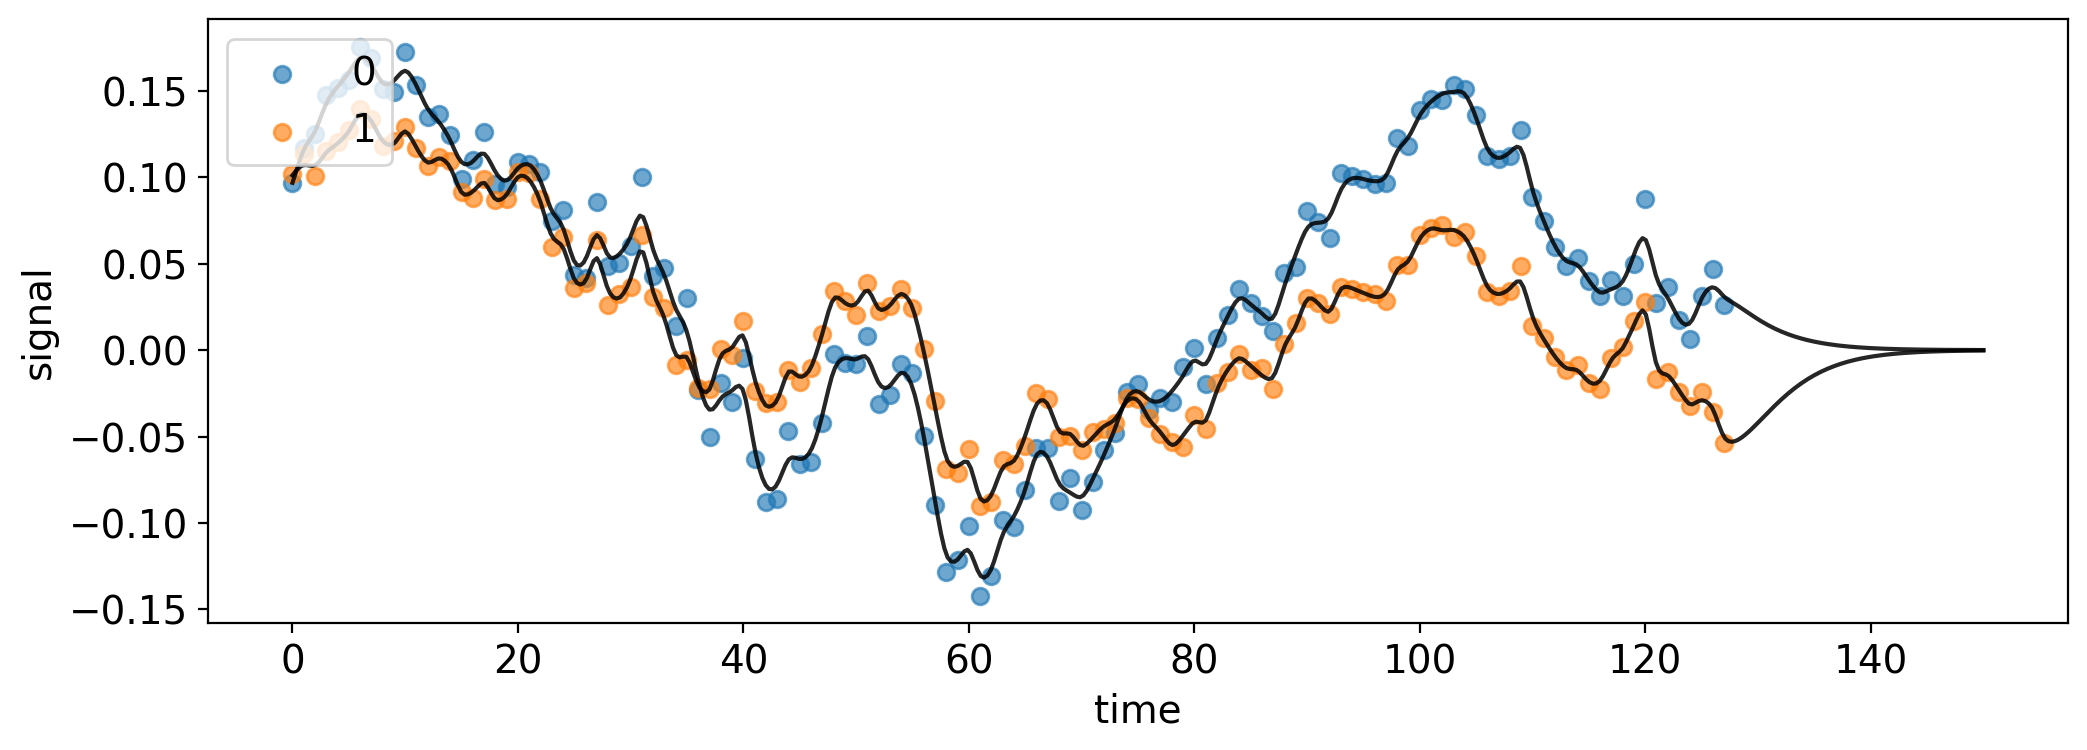

In [ ]:
plt.figure(figsize=(12,4))

for idx, _ in enumerate(data):
    _xdata = _[0]
    _ydata = _[1]
    plt.scatter(_xdata, _ydata, alpha=0.65, label=idx, zorder=1)

for idx, _ in enumerate(y_star):
    _xdata = x_star
    _ydata = _
    plt.plot(_xdata, _ydata, alpha=0.85, color='k', zorder=1)

plt.legend(loc='upper left')
plt.xlabel('time')
plt.ylabel('signal')

plt.show()

# Teenager example

In [ ]:
df = df_raw.tail(128)

x0 = df.index.to_numpy()
y0 = df['AAPL'].to_numpy()

x1 = df.index.to_numpy()
y1 = df['VOO'].to_numpy()

x2 = df.index.to_numpy()
y2 = df['PXI'].to_numpy()

xdata = [x0, x1, x2]
ydata = [y0, y1, y2]


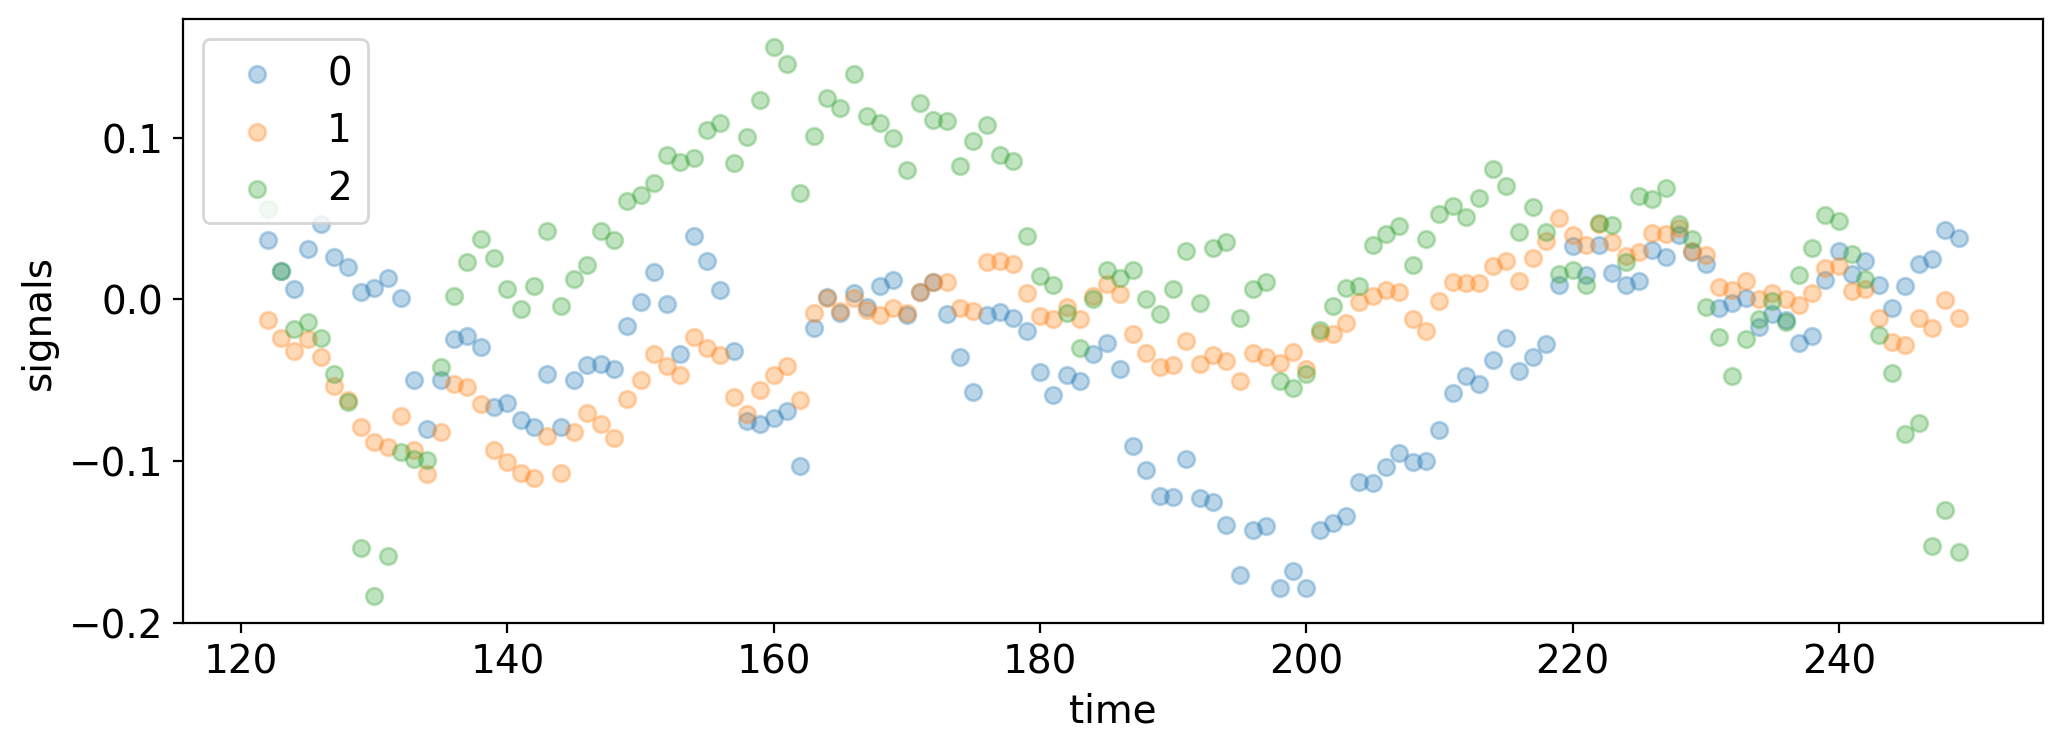

In [ ]:
plt.figure(figsize=(12,4))

for idx in range(len(xdata)):
    _xdata = xdata[idx]
    _ydata = ydata[idx]
    plt.scatter(_xdata, _ydata, alpha=0.3, marker='o', label=idx, zorder=1)

plt.legend(loc='upper left')
plt.xlabel('time')
plt.ylabel('signals')

plt.show()


In [ ]:
# Define a basic Kernel

def matern(t, s, params=1):
    sigma = params
    d = jnp.abs(t - s)
    u = jnp.power(3,1/2) * d / sigma
    return sigma**2 * (1+u) * jnp.exp(-u)

vmatern = vmap(matern, in_axes=(0, None, None))
vvmatern = vmap(vmatern, in_axes=(None, 0, None))

In [ ]:
params = [
    [1, 0.1, 0.1],
    [0.1, 1, 0.1],
    [0.1, 0.1, 1]
]


In [ ]:
K = []

for i in range(len(xdata)):
    row = []
    for j in range(len(xdata)):
        if i == j:
            sigma2 = 0.05
        else:
            sigma2 = 0
        Kij = vmatern(xdata[i], xdata[j], params[i][j]) + sigma2
        row.append(Kij)
    K.append(row)

K = jnp.block(K)

coef = jnp.linalg.solve(K, jnp.concatenate((y0, y1, y2)))

In [ ]:
def Kstar(x_star, x_data, params):
    _ = []
    for i in range(len(x_data)):
        row = []
        for j in range(len(x_data)):
            Kij = vmatern(x_data[j], x_star, params[i][j])
            row.append(Kij)
        _.append(row)
    return np.block(_)

x_star = 210
y_star = Kstar(x_star, xdata, params) @ coef

In [ ]:
y_star

Array([-0.05593382,  0.01382159,  0.03633523], dtype=float64)

In [ ]:
xplot = jnp.linspace(128, 256, 512)
yplot = []
for _ in xplot:
    yplot.append(Kstar(_, xdata, params) @ coef)

yplot = jnp.asarray(yplot).T


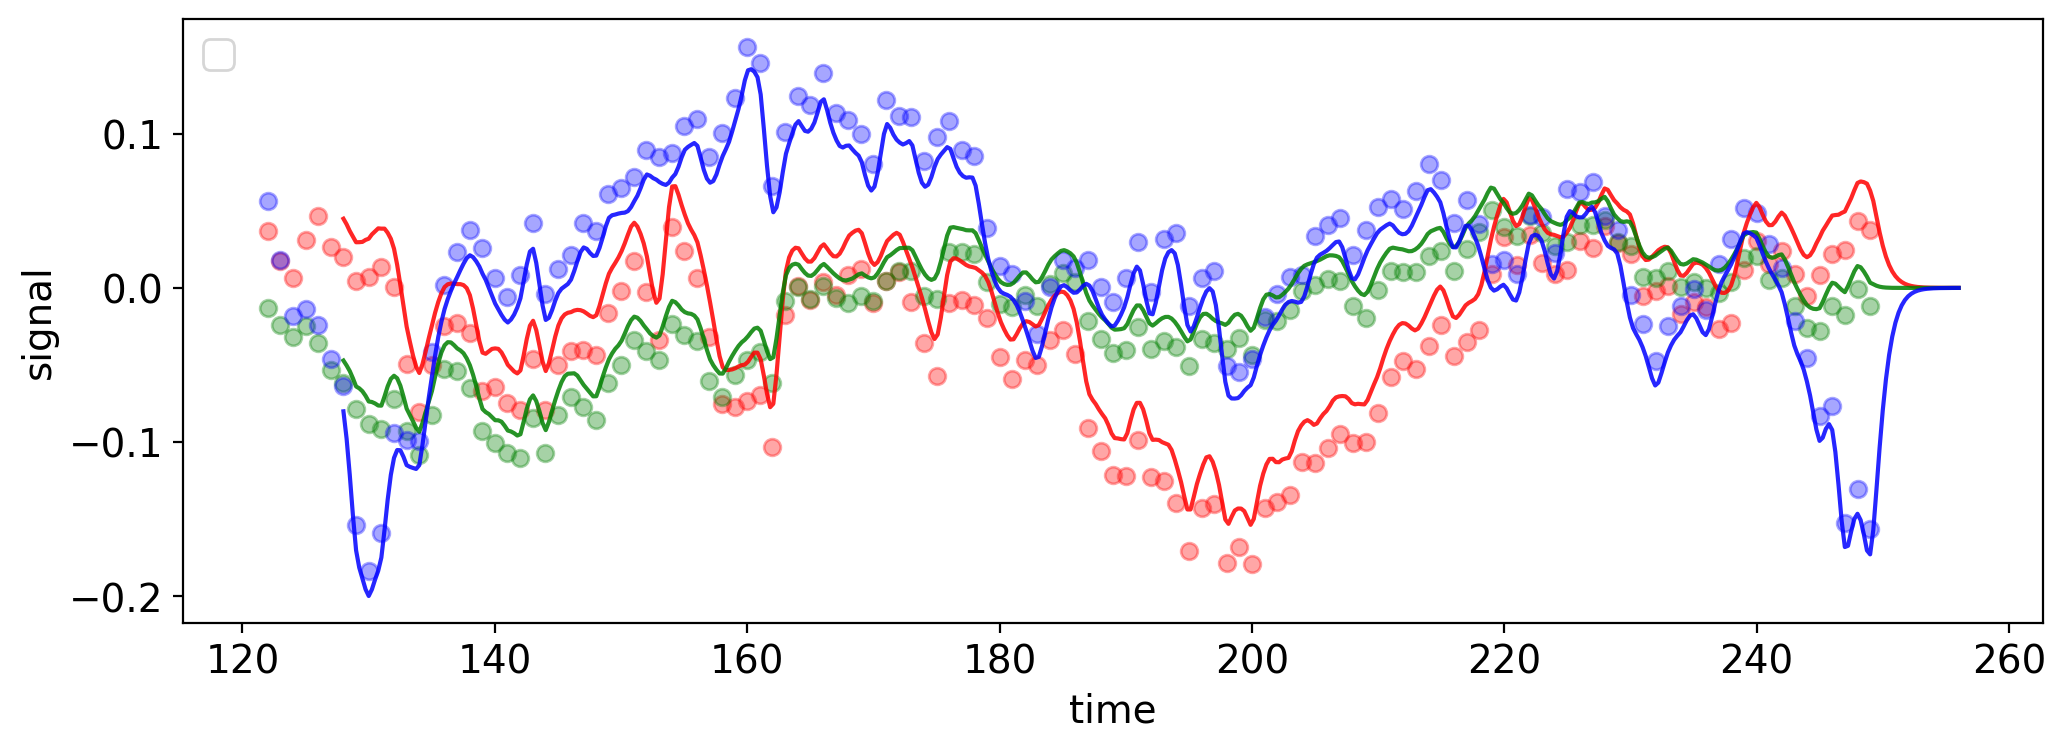

In [ ]:
colors = ['r', 'g', 'b']

plt.figure(figsize=(12,4))

for idx in range(len(yplot)):
    color = colors[idx]
    _xdata = xplot
    _ydata = yplot[idx]
    plt.scatter(xdata[idx], ydata[idx], alpha=0.35, color=color, zorder=0)
    plt.plot(_xdata, _ydata, alpha=0.85, color=color, zorder=1)

plt.legend(loc='upper left')
plt.xlabel('time')
plt.ylabel('signal')

plt.show()

# Young adult example

In [ ]:
df = df_raw

x0 = df.index.to_numpy()
y0 = df['AAPL'].to_numpy()

x1 = df.index.to_numpy()
y1 = df['VOO'].to_numpy()

x2 = df.index.to_numpy()
y2 = df['PXI'].to_numpy()

xdata = [x0, x1, x2]
ydata = [y0, y1, y2]


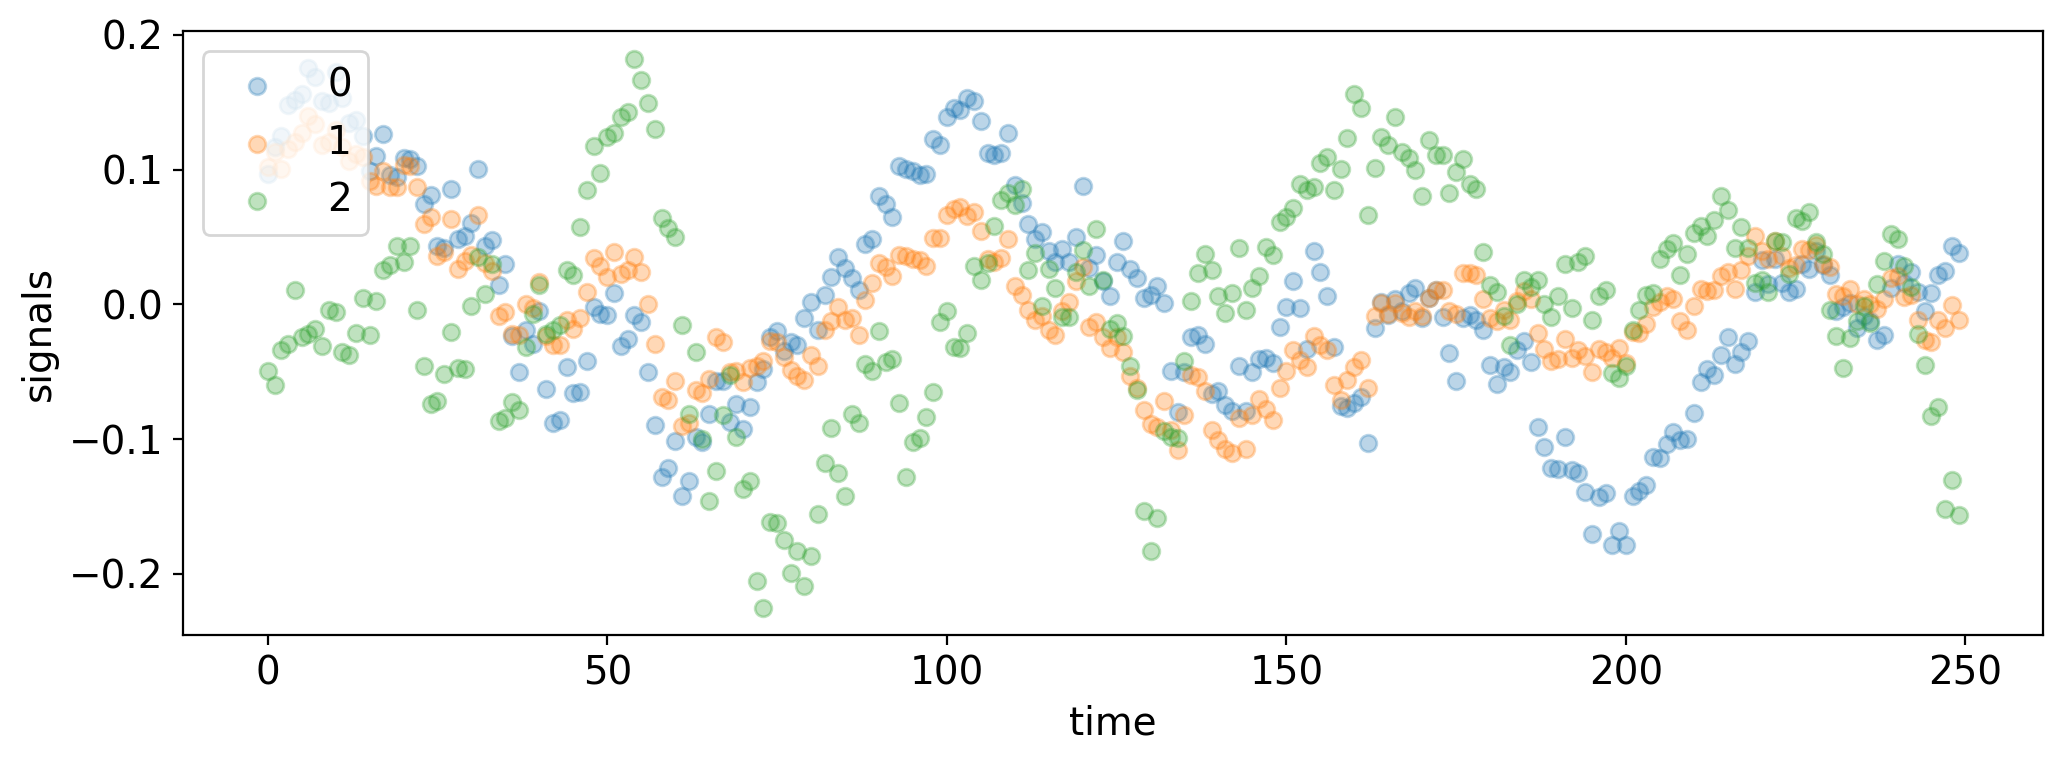

In [ ]:
plt.figure(figsize=(12,4))

for idx in range(len(xdata)):
    _xdata = xdata[idx]
    _ydata = ydata[idx]
    plt.scatter(_xdata, _ydata, alpha=0.3, marker='o', label=idx, zorder=1)

plt.legend(loc='upper left')
plt.xlabel('time')
plt.ylabel('signals')

plt.show()


In [ ]:
# Define a exotic Kernel

def exotic(t, s, params):
    length, period, sigma, alpha1, alpha2 = jnp.exp(params)
    d = jnp.abs(t - s)

    u = jnp.power(3,1/2) * d / sigma
    k1 = sigma**2 * (1+u) * jnp.exp(-u)

    omega = 2*jnp.pi/period
    k2 = jnp.exp(- (2/length**2) * jnp.sin(0.5*omega*d)**2)

    return alpha1*k1 + alpha2*k2

vexotic = vmap(exotic, in_axes=(0, None, None))
vvexotic = vmap(exotic, in_axes=(None, 0, None))

NameError: ignored

In [ ]:
p1 = jnp.array([-1, jnp.log(45), jnp.log(45), 2, 2])
p2 = jnp.array([-1, jnp.log(20), jnp.log(20), -1, -1])

params = [
    [p1, p2, p2],
    [p2, p1, p2],
    [p2, p2, p1]
]


In [ ]:
K = []

for i in range(len(xdata)):
    row = []
    for j in range(len(xdata)):
        if i == j:
            sigma2 = 1
        else:
            sigma2 = 0
        Kij = vexotic(xdata[i], xdata[j], params[i][j]) + sigma2
        row.append(Kij)
    K.append(row)

K = jnp.block(K)

coef = jnp.linalg.solve(K, jnp.concatenate((y0, y1, y2)))

In [ ]:
def Kstar(x_star, x_data, params):
    _ = []
    for i in range(len(x_data)):
        row = []
        for j in range(len(x_data)):
            Kij = vexotic(x_data[j], x_star, params[i][j])
            row.append(Kij)
        _.append(row)
    return np.block(_)

x_star = 210
y_star = Kstar(x_star, xdata, params) @ coef

In [ ]:
xplot = jnp.linspace(0, 255, 512)
yplot = []
for _ in xplot:
    yplot.append(Kstar(_, xdata, params) @ coef)

yplot = jnp.asarray(yplot).T


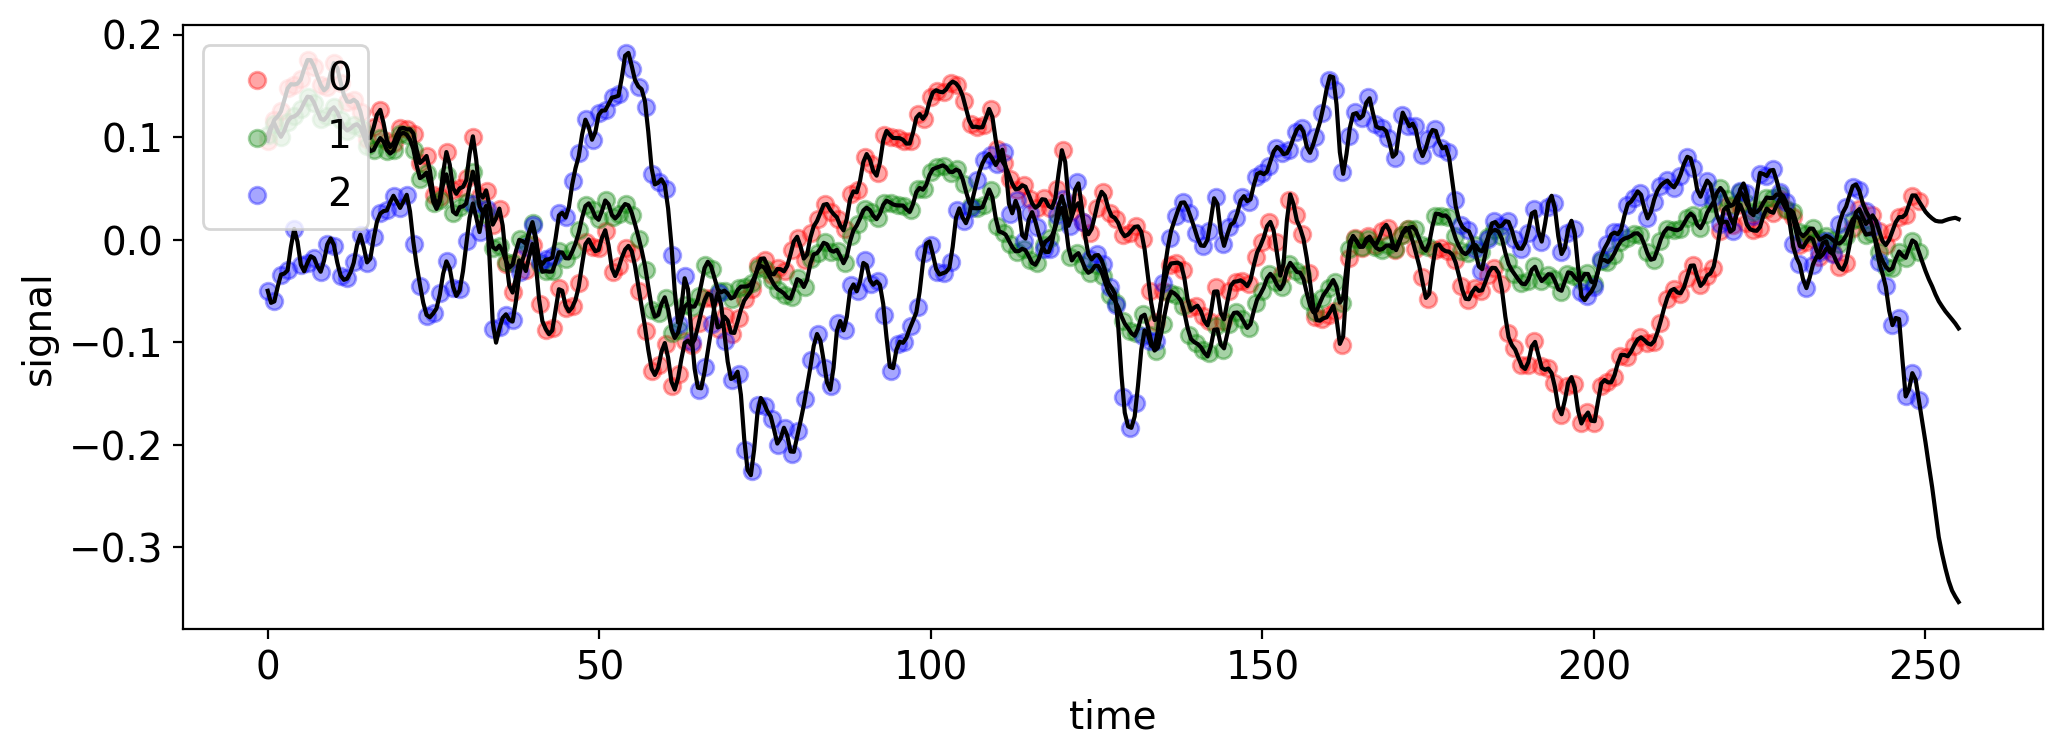

In [ ]:
colors = ['r', 'g', 'b']

plt.figure(figsize=(12,4))

for idx in range(len(yplot)):
    color = colors[idx]
    _xdata = xplot
    _ydata = yplot[idx]
    plt.scatter(xdata[idx], ydata[idx], alpha=0.35, label=idx, color=color, zorder=0)
    plt.plot(_xdata, _ydata, alpha=1, color='k', zorder=1)

plt.legend(loc='upper left')
plt.xlabel('time')
plt.ylabel('signal')

plt.show()